In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import scale, StandardScaler,FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc,confusion_matrix,roc_auc_score, precision_recall_curve
from sklearn.cross_decomposition import PLSRegression

import random

SEED = 520

In [ ]:
df = pd.read_csv('raw_data.csv', sep=';')

In [ ]:
df.shape

In [ ]:
col_spectre = df.columns[4:-1]
other_col = ["patient_name",'cell_name','cell_type','patient_state','spectre']

In [ ]:
spectre_1 = df[df["spectre"] == 1]
spectre_2 = df[df["spectre"] == 2]
spectre_3 = df[df["spectre"] == 3]

In [ ]:
print(spectre_1.shape)
print(spectre_2.shape)
print(spectre_3.shape)

In [ ]:
col_spectre = list(df.columns[4:-1])
col_spectre.append('cell_name')

In [ ]:
new_df = spectre_1.merge(spectre_2[col_spectre], how='left', on='cell_name', suffixes=(None,"_2"))
new_df = new_df.merge(spectre_3[col_spectre], how='left', on='cell_name', suffixes=(None,"_3"))

In [ ]:
new_df

In [ ]:
print('Cellule avec 3 spectre :', len(new_df[~new_df['lambda_997_3'].isna()]))
print('Cellule avec 2 spectre ou moins :', len(new_df[new_df['lambda_997_3'].isna()]))
print('Cellule avec 1 spectre :', len(new_df[new_df['lambda_997_2'].isna()]))

In [ ]:
# We replace missing value by 0
new_df = new_df.fillna(0)

In [ ]:
new_df['cell_type'] = new_df['cell_type'].replace('B',1)
new_df['cell_type'] = new_df['cell_type'].replace('TNK',0)

In [ ]:
# Preprocess the data

label = new_df['cell_type']
data = new_df.drop(['cell_type','cell_name','patient_name','patient_state'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(data, label,
                                                    test_size=0.2, stratify=label, random_state=SEED)

In [ ]:
print(x_train.shape)
print(x_test.shape)

In [ ]:
# Find best parameters for Random Forrest using Cross Validation
clf = RandomForestClassifier(random_state=SEED)

param_grid = {"max_depth" : [6, 15]}

gridsearch_rf = GridSearchCV(clf,param_grid=param_grid, 
                             cv=10, 
                             scoring='f1', 
                             return_train_score=True,
                             refit=True)
gridsearch_rf.fit(x_train, y_train.values.ravel())
pd.DataFrame(gridsearch_rf.cv_results_).T 

## 2eme Methode : Predire par spectre

In [46]:
df = pd.read_csv('raw_data.csv', sep=';')

In [47]:
col_spectre = df.columns[4:-1]
other_col = ["patient_name",'cell_name','cell_type','patient_state','spectre']

# Preprocess the data
df['cell_type'] = df['cell_type'].replace('B',1)
df['cell_type'] = df['cell_type'].replace('TNK',0)

# One hot the specter number feature
for i in df['spectre'].unique():
    df['spectre_'+str(int(i))] = np.where(df['spectre'] == i, 1, 0)

In [50]:
# Notre train set contiendra les spectres de 29 patients, tandis que le test set sera constitué de 6 patients
# On fait en sorte que le test set ait autant de patients sains que malades.
patient_malade = list(df[df['patient_state'] == 'malade'].patient_name.unique())
patient_sain = list(df[df['patient_state'] == 'sain'].patient_name.unique())

patient_test = random.sample(patient_malade, 2) + random.sample(patient_sain, 2)
label = df['cell_type']


x_train = df.loc[~df.patient_name.isin(patient_test)]
y_train = df.loc[~df.patient_name.isin(patient_test)]['cell_type']
x_test = df.loc[df.patient_name.isin(patient_test)]
y_test = df.loc[df.patient_name.isin(patient_test)]['cell_type']


#x_train, x_test, y_train, y_test = train_test_split(df, label, test_size=0.2, stratify=label)

print("Taille training set :", x_train.shape)
print("Taille test set :", x_test.shape)
print("Nombre de patients dans le train vs test", x_train['patient_name'].nunique(),'/', x_test['patient_name'].nunique())
print("Nombre de spectres dans train vs test:", len(x_train), '/', len(x_test))
print("Ratio B-cell target train vs test" , len(y_train[y_train == 1])/len(y_train),'/',len(y_test[y_test == 1])/len(y_test))
print("Patients dans le train set :", x_train['patient_name'].unique())
print("Patients dans le test set :", x_test['patient_name'].unique())

# Remove features that won't be used for training
x_train = x_train.drop(['cell_type','cell_name','patient_name','patient_state','spectre'], axis=1)
x_test = x_test.drop(['cell_type','cell_name','patient_name','patient_state','spectre'], axis=1)

Taille training set : (6319, 1007)
Taille test set : (878, 1007)
Nombre de patients dans le train vs test 29 / 4
Nombre de spectres dans train vs test: 6319 / 878
Ratio B-cell target train vs test 0.4002215540433613 / 0.4316628701594533
Patients dans le train set : ['P2_ULC80' 'P2_ULC81' 'P1_ULC86' 'P1_ULC87' 'P2_ULC88' 'P1_ULC89'
 'P1_ULC91' 'P2_ULC93' 'P2_ULC96' 'P1_ULC98' 'P2_ULC99' 'P1_ULC100'
 'P1_ULC101' 'P1_ULC103' 'P1_ULC106' 'P1_ULC127' 'P2_ULC128' 'P2_ULC129'
 'P1_ULC133' 'P1_ULC137' 'P2_ULC139' 'P2_ULC142' 'P1_ULC144' 'P2_ULC146'
 'P1_ULC147' 'P1_ULC148' 'P2_ULC149' 'P1_ULC151' 'P1_ULC156']
Patients dans le test set : ['P1_ULC95' 'P2_ULC102' 'P2_ULC135' 'P1_ULC138']


In [51]:
# Apply a Partial least squares regression to reduce the dimensionality
pls = PLSRegression(n_components=20)

spectre_transformed_train = pd.DataFrame(pls.fit_transform(x_train[col_spectre], y_train)[0])
spectre_transformed_test = pd.DataFrame(pls.transform(x_test[col_spectre]))

col_spectre_pls = spectre_transformed_train.columns

x_train = pd.concat([x_train.iloc[:,-3:].reset_index(), spectre_transformed_train], axis=1).drop("index", axis=1)
x_test = pd.concat([x_test.iloc[:,-3:].reset_index(), spectre_transformed_test], axis=1).drop("index", axis=1)

In [52]:
# We scale continous feature
columnTransformer = ColumnTransformer([['scaler',
                                        StandardScaler(),
                                        col_spectre_pls]],
                                      remainder='passthrough',
                                      )

x_train_transformed = np.array(columnTransformer.fit_transform(x_train))
x_test_transformed = np.array(columnTransformer.transform(x_test))

In [53]:
# Find best parameters for Random Forrest using Cross Validation
clf = RandomForestClassifier(random_state=SEED)

param_grid = {"max_depth" : [15],
             "n_estimators": [50]}

gridsearch_rf = GridSearchCV(clf,param_grid=param_grid, 
                             cv=20, 
                             scoring='f1', 
                             return_train_score=True,
                             refit=True)
gridsearch_rf.fit(x_train_transformed, y_train.values.ravel())
pd.DataFrame(gridsearch_rf.cv_results_).T

,0
mean_fit_time,0.856714
std_fit_time,0.013879
mean_score_time,0.011339
std_score_time,0.000656
param_max_depth,15
param_n_estimators,50
params,"{'max_depth': 15, 'n_estimators': 50}"
split0_test_score,0.886525
split1_test_score,0.798561
split2_test_score,0.755981


In [54]:
# Find best parameters for logistic regression using Cross Validation
clf = LogisticRegression(random_state=SEED, solver='liblinear')
param_grid_rl = {"C" : [0.01,0.1,0.5,1.0]}
gridsearch_rl = GridSearchCV(clf,param_grid=param_grid_rl, 
                             cv=10, 
                             scoring='recall', 
                             return_train_score=True,
                             )
gridsearch_rl.fit(x_train_transformed, y_train.values.ravel())
pd.DataFrame(gridsearch_rl.cv_results_).T

,0,1,2,3
mean_fit_time,0.018289,0.01669,0.016091,0.018189
std_fit_time,0.003163,0.001791,0.001639,0.002521
mean_score_time,0.002598,0.001899,0.002099,0.002398
std_score_time,0.0008,0.000538,0.000538,0.000663
param_C,0.01,0.1,0.5,1.0
params,{'C': 0.01},{'C': 0.1},{'C': 0.5},{'C': 1.0}
split0_test_score,0.940711,0.960474,0.964427,0.964427
split1_test_score,0.798419,0.806324,0.806324,0.806324
split2_test_score,0.735178,0.735178,0.735178,0.731225
split3_test_score,0.849802,0.849802,0.849802,0.849802


In [56]:
# We retrain our model on the whole train set using the best hyperparameters
clf = RandomForestClassifier(**gridsearch_rf.best_params_)
clf.fit(x_train_transformed, y_train.values.ravel())

RandomForestClassifier(max_depth=15, n_estimators=50)

In [60]:
# We retrain our model on the whole train set using the best hyperparameters
clf = LogisticRegression(**gridsearch_rl.best_params_)
clf.fit(x_train_transformed, y_train.values.ravel())

LogisticRegression(C=0.5)

### Result on test set

In [61]:
# We apply our model on the test set
y_result = clf.predict_proba(x_test_transformed)[:,1]
y_train_result = clf.predict_proba(x_train_transformed)[:,1]

In [62]:
# Get false positive rate and true postive rate on test set
fpr, tpr, _ = roc_curve(y_test, y_result)
roc_auc = roc_auc_score(y_test, y_result)

#On train set
fpr_t, tpr_t, _ = roc_curve(y_train, y_train_result)
roc_auc_t = roc_auc_score(y_train, y_train_result)

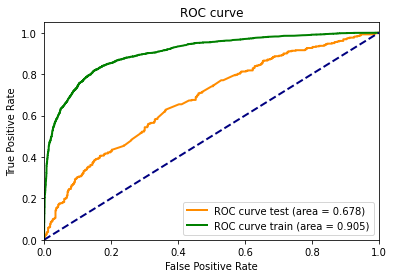

In [63]:
# We plot the ROC curve of the result on the train and test data
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve test (area = %0.3f)' % roc_auc)
plt.plot(fpr_t, tpr_t, color='green',
         lw=lw, label='ROC curve train (area = %0.3f)' % roc_auc_t)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [64]:
# Show confusion matrix
y_result = clf.predict_proba(x_test_transformed)[:,1]
y_result = np.where(y_result < 0.5, 0, 1)
conf_mx = confusion_matrix(y_test, y_result)

print("Accuracy :",(conf_mx[0][0]+conf_mx[1][1])/len(y_result))
print("Recall :",(conf_mx[1][1])/len(y_test[y_test==1]))
print("Precision :",(conf_mx[1][1])/len(y_result[y_result==1]))

Accuracy : 0.6389521640091116
Recall : 0.43007915567282323
Precision : 0.6174242424242424


In [65]:
# We select all the patients that was not used for training or validation
test_set = df[df.patient_name.isin(patient_test)]
test_set = test_set.assign(prediction = clf.predict_proba(x_test_transformed)[:, 1])

# We aggregate our test set at the cell level to get the prection for each cell
cell_test = test_set.groupby(['patient_name','cell_name']).agg({'cell_type':"first",
                                                              'patient_state':"first",
                                                              "spectre":'count',
                                                              'prediction':"mean"})

<AxesSubplot:ylabel='Count'>

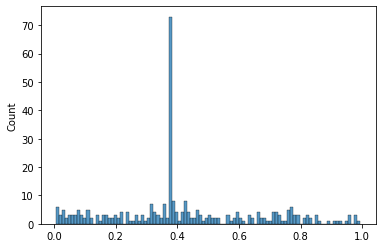

In [66]:
sns.histplot(cell_test.prediction.values, bins=100)

In [70]:
# We one hot encode the label
cell_test['TNK'] = np.where(cell_test['cell_type']==0, 1, 0)
cell_test['B'] = np.where(cell_test['cell_type']==1, 1, 0)

# Using a threshold of 0.5, we assign label to the mean prediction of all specters for one cell

cell_test['predicted_type'] = np.where(cell_test['prediction'] < 0.4, 0, 1)

# We one hot encode the predicted label
cell_test['TNK_predicted'] = np.where(cell_test['predicted_type'] == 0, 1, 0)
cell_test['B_predicted'] = np.where(cell_test['predicted_type'] == 1, 1, 0)

# We aggregate our test set at the patient level to get the prection for each patient

patient_df = cell_test.groupby('patient_name').agg({'TNK':sum, 
                                                  'B':sum,
                                                  'TNK_predicted':sum,
                                                  'B_predicted':sum,
                                                  'patient_state':"first", 
                                                  'spectre':'sum'})

patient_df['cell_number'] = patient_df['TNK'] + patient_df['B']
patient_df['ratio_B'] = patient_df['B']/patient_df['cell_number']
patient_df['ratio_B_predicted'] = patient_df['B_predicted']/patient_df['cell_number']

patient_df['diff_ratio'] = abs(patient_df['ratio_B_predicted'] - patient_df['ratio_B'])
patient_df['predicted_state'] = np.where(patient_df['ratio_B_predicted'] < 0.5, "sain", 'malade')

patient_df.sort_values("ratio_B", ascending=False)

,TNK,B,TNK_predicted,B_predicted,patient_state,spectre,cell_number,ratio_B,ratio_B_predicted,diff_ratio,predicted_state
patient_name,,,,,,,,,,,
P2_ULC135,2,51,5,48,malade,158,53,0.962264,0.905660,0.056604,malade
P2_ULC102,13,34,24,23,malade,103,47,0.723404,0.489362,0.234043,sain
P1_ULC138,106,45,133,18,sain,440,151,0.298013,0.119205,0.178808,sain
P1_ULC95,51,11,29,33,sain,177,62,0.177419,0.532258,0.354839,malade


In [72]:
print('Moyenne de l\'erreur', patient_df['diff_ratio'].mean())
print('Variance de l\'erreur',patient_df['diff_ratio'].var())
print('Patients malades bien prédit', len(patient_df[(patient_df.predicted_state == patient_df.patient_state) \
                                                     & (patient_df.patient_state == "malade")]),'/',
                                      len(patient_df[patient_df.patient_state == 'malade']))

print('Patients sains bien prédit', len(patient_df[(patient_df.predicted_state == patient_df.patient_state) \
                                                     & (patient_df.patient_state == "sain")]),'/',
                                      len(patient_df[patient_df.patient_state == 'sain']))

Moyenne de l'erreur 0.20607324586842046
Variance de l'erreur 0.015332655013484043
Patients malades bien prédit 1 / 2
Patients sains bien prédit 1 / 2


## TO DO

* Retrain the model multiple time with different splits and compute the mean difference of variation as well as the variance
* Find a way of finding the optimal threshold (which maximise the recall) more rigoursly
* Print the accuracy, recall, etc
* 